# Проект: Система поиска подходящих товаров на основе дообученной CLIP модели


## Постановка задачи

Нужно реализовать такую систему: пользователь описывает вещь словами, система находит и показывает наиболее близкие позиции из базы. Компания выходит на международный рынок, поэтому система будет работать на английском языке.

Нужно:
- дообучить модель CLIP на датасете товаров из магазинов одежды,
- реализовать систему поиска изображений товаров по текстовым запросам.

## Критерии успеха

- Целевые значения **среднего CLIP** score должны быть **выше 30**.
- Ожидаемый результат: реализована поисковая система, способная принимать текстовые запросы и возвращать наиболее релевантные изображения из датасета. Система должна работать эффективно, то есть не пересчитывать каждый раз векторные представления картинок.

<div class="alert alert-secondary" style="background-color:#D9EEE1;color:black;">

## Описание данных
[Ссылка](https://www.kaggle.com/datasets/nirmalsankalana/fashion-product-text-images-dataset) на датасет.

Датасет содержит картинки и таблицу `data.csv`.

В этой таблице такие поля: 
- `image` — название файла изображения в папке с изображениями.
- `description` — описание элемента одежды, изображённого на картинке.
- `display name` — название элемента на картинке.
- `category` — категория элемента одежды.

В проекте вам понадобятся только первые два столбца: `image` — для визуальных данных, `description` — для текстовых.

## Инициализация

In [ ]:
JUST_DEBUG_ON_CPU = True # 👷🚧🚧🚧🚧🚧 переключить в False при итоговом обучении и замере
DEBUG_MAX_ELEMENTS = 10

RANDOM_STATE = 42

DATA_CSV_PATH = "archive/data.csv"
IMAGES_PATH = "archive/data/"

#MODEL_NAME = "openai/clip-vit-base-patch32"
MODEL_NAME = "openai/clip-vit-base-patch32" if not JUST_DEBUG_ON_CPU else "openai/clip-vit-base-patch16"

BATCH_SIZE = 32 if not JUST_DEBUG_ON_CPU else 3
NUM_EPOCHS = 4 if not JUST_DEBUG_ON_CPU else 1
CHECKPOINT_DIR = "clip_checkpoints"

### Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import textwrap
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from tqdm.notebook import tqdm

C:\Users\Papa\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Этап 1. Fine-tuning CLIP

## Загрузка и исследовательский анализ данных


In [3]:
df = pd.read_csv(DATA_CSV_PATH).drop(columns=['display name', 'category'])

In [4]:
if JUST_DEBUG_ON_CPU:
    df = df[:500]

In [5]:
pd.options.display.max_colwidth = 1000

In [6]:
df.head()

,image,description
0,3238.jpg,"Round toed, black sports shoes with red accents, low top styling and central lace-ups Leather upper with stitched detail, overlay, Formstrip and Ducati branding on the sides and reinforced heel collar with branding Soft tongue and inner, branding on the tongue Cushioned footbed with branding at the heel Printed detail at the midsole Textured rubber outsole with patterned grooves and branding Warranty: 3 months against manufacturing defects only"
1,43044.jpg,"Style Note Built with the breathability and zero-distraction Fit that athletes demand, these boardshorts come in a body-friendly design. These high-performance shorts are great for a day out at the beach and are designed to aid your aquatic performance. Team them with T-shirts and flip flops. Product Details Charcoal grey boardshorts, with a velcro closure and a cord tie detail, zipped pocket and a nike swoosh on left leg Material and Care 100% polyester Machine wash separately in cold water using a mild detergent Do not bleach Tumble dry low Cool iron; do not iron on decorations Size and fit Regular fit"
2,54018.jpg,"Teal handbag that has stitch detailing with a pleated and panel design on the front One main zipped compartment that has an inner zipped pocket and an organiser sleeve One zipped pocket on the front One long, adjustable strap woven through metallic loops for carrying ease and style One zipped pocket at the back"
3,8141.jpg,"Perfectly stylish, this fastrack analog wrist watch is a great buy for those who enjoy performance and style. With excellent touches and comfort, this watch makes for an excellent daily wear. Case diameter : 30 mm Case thickness : 5 mm Dial shape : Square Plastic case with a fixed bezel for added durability, style and comfort Leather strap with stitch detailing, brand name printed on the inner part and a tang clasp Silver dial in a radiating pattern with minute marking in pink from 6 o& rsquo clock to 12 o& rsquo clock position, brand name at 3 o& rsquo clock position and brand logo at 12 o& rsquo clock position Quartz movement of time display with carved out hour and minute hands Screw to reset time Solid case back made of stainless steel for enhanced durability Water resistance at 30 meters, allowing you to use it even when swimming"
4,22245.jpg,"These id mid-top chukka shoes add a fresh spin on a classic style with its wide midsole. The humble sneaker reached a new high with this casual shoe, with its contrasting textures and subtle colour map. Wear this with a crisp shirt, a half zippered sweater and a jacket or blazer on top to achieve the perfect layered look. Pair this with your favourite jeans or chinos. Upper Low top suede upper with synthetic overlay on the heel collar Perforations in the midfoot region for ventilation Central lace ups Padded tongue and collar Mesh lining Contrast stitch detailing Midsole Thick EVA midsole Outsole Rubber outsole with a stacked heel and grooves Shoe care Wipe with a dry cloth to remove dust"


Сразу отделим тестовую выборку, чтобы её не касалась предобработка и очистка.

In [7]:
df_train, df_val = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_STATE,
    shuffle=True
)

In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        450 non-null    object
 1   description  449 non-null    object
dtypes: object(2)
memory usage: 7.2+ KB


Есть пустые поля с описаниями. Такие образцы нам не нужны - удалим их:

In [10]:
df_train = df_train.dropna()

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 449 entries, 0 to 449
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        449 non-null    object
 1   description  449 non-null    object
dtypes: object(2)
memory usage: 10.5+ KB


Изучим дубликататы датафейрма:

In [12]:
df_train['image'].duplicated().sum()

0

In [13]:
df_train['description'].duplicated().sum()

8

In [14]:
df_train['description'].value_counts()

description
-                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

Дубликаты есть, в т. ч. без значимых описаний. Удалим такие:

In [15]:
english_pattern = r'[a-zA-Z]'
mask = ~df_train['description'].str.contains(english_pattern, na=False)
df_train[mask]['description'].value_counts()

description
-    7
Name: count, dtype: int64

In [16]:
df_train = df_train[~mask]

In [17]:
df_train['description'].value_counts()

description
Style Note                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Посмотрим на некоторые группы картинок

In [18]:
def show_images (df_arg):
    for _, row in df_arg.iterrows():
        image_path = os.path.join (IMAGES_PATH, row['image'])
    
        image = Image.open(image_path)
        
        print (f"⬇------------------- изображение {row['image']} -------------------⬇")
        wrapped_description = textwrap.fill(row['description'], width=80)
        print (wrapped_description)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

⬇------------------- изображение 40652.jpg -------------------⬇
Style Note


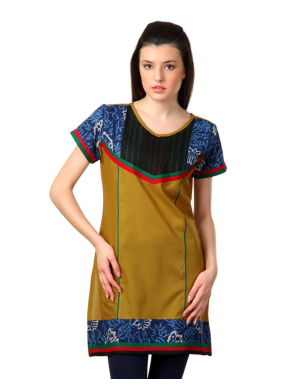

⬇------------------- изображение 40655.jpg -------------------⬇
Style Note


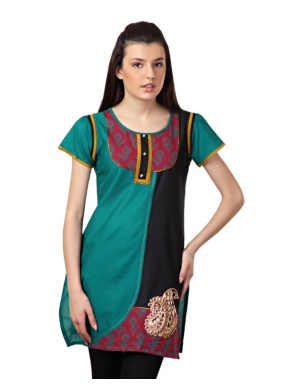

⬇------------------- изображение 40626.jpg -------------------⬇
Style Note


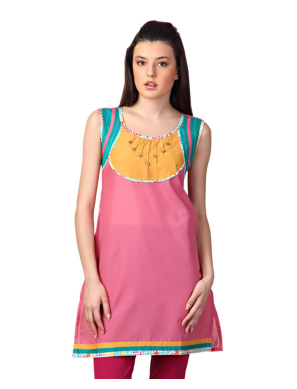

In [19]:
show_images (df_train [df_train['description'] == 'Style Note'][:3])

-- такие дубликаты удалим, т. к. описание бессмысленное, а картинки противоречивые.

In [20]:
df_train = df_train [df_train['description'] != 'Style Note']

⬇------------------- изображение 55946.jpg -------------------⬇
Chip-resistant and prevents yellowing of nails Fast drying and long wearing
Simple one stroke application


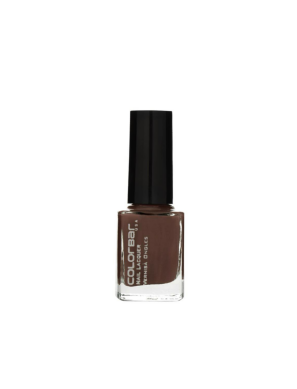

In [21]:
show_images (df_train [df_train['description'] == 'Chip-resistant and prevents yellowing of'
                 ' nails Fast drying and long wearing Simple one stroke application'][:3])

-- такие дубликаты оставим.

Посмотрим разрешения картинок:

In [22]:
def get_resolution (row):
    image_path = os.path.join (IMAGES_PATH, row['image'])
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width, height
    except FileNotFoundError:
        print(f"Ошибка: Файл не найден по пути {image_path}")
    except Exception as e:
        print(f"Произошла ошибка при обработке изображения: {e}")    


df_train [['width', 'height']] = df_train.apply(get_resolution, axis=1, result_type='expand')

In [23]:
df_train['width'].value_counts()

width
1080    439
Name: count, dtype: int64

In [24]:
df_train['height'].value_counts()

height
1440    439
Name: count, dtype: int64

Все изображения имеют разрешение  1080х1440

Посмотрим на несколько случайных изображений и текстов, оценим их соответствие:

In [25]:
pd.options.display.max_colwidth = 10

⬇------------------- изображение 24523.jpg -------------------⬇
Composition Blue printed round neck kurta made of blended cotton fabric, has a
split neckline, three quarter sleeves, mirror and thread work on the yoke and a
vented hem  Fit Regular  Wash care Hand wash separately in cold water using a
mild detergent as colour may bleed Flat dry inside out in shade Warm iron  The
inspiration for this kurta from mother earth is the retro-esque fusion of ethnic
apparel and smart workwear. This piece epitomizes how fashion, vintage styling
and comfort unite to create the perfect Indian tunic. Mother Earth uses hand
processed fabrics including natural and Azo free dyes. Woven with slub yarns for
an authentic vintage feel. Those interested in colourblocking can wear this with
bright contrasting capris or pants. Others, who want to keep their look classic
and chic, can pair this with jeggings and embellished slippers.  Model
statistics The product is a size S on a model of height 5'8" and chest

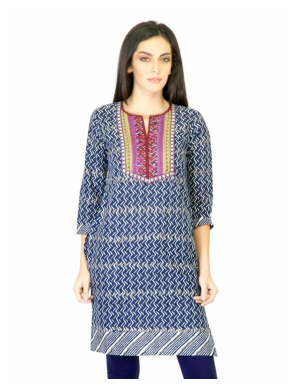

⬇------------------- изображение 42147.jpg -------------------⬇
Style Note This vintage style nike Sweet Classic Leather shoe is a perfect
fusion of street fashion and tennis glam. Designed for the tennis lover, these
shoes blend function and fashion effortlessly, to make you look fabulous on and
off the court.  Product Details White leather shoe with central lace-ups,
overlays, nike swoosh and stitched detailing Padded tongue and inner Tough
rubber midsole Durable rubber outsole with herringbone grooves  Material and
Care Leather Wipe surface with a clean, damp cloth Do not store in direct
sunlight


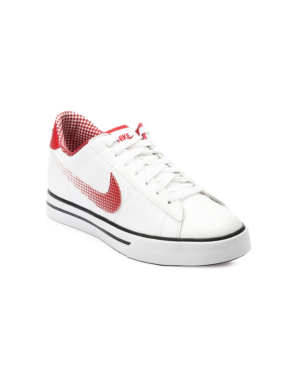

⬇------------------- изображение 26737.jpg -------------------⬇
Style Note Straight from the Sports lifestyle reebok collection of deodorants
comes this fabulous Reesport deodorant. This amazing fragrant sensation is for
men and comes in a cylindrical bottle Caution Flammable Keep away from sources
of ignition Keep away from children Do not use near fire, flame or heat Avoid
spraying near the eyes Quantity : 150 ml


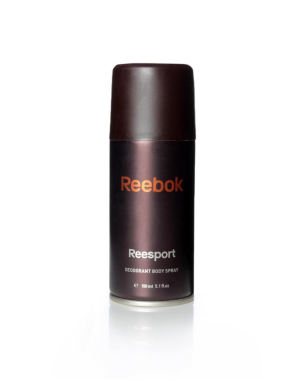

⬇------------------- изображение 57153.jpg -------------------⬇
Peach knit, cropped T-shirt, has a round neckline, short extended sleeves and a
graphic print with red beaded detail on the front


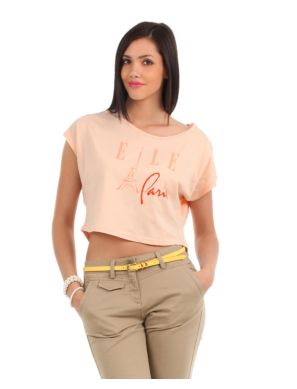

⬇------------------- изображение 40691.jpg -------------------⬇
Style Note The simple design of these numero uno shoes have an understated
elegance. The comfortable design takes you through the day in style. Team these
up with jeans and long sleeved grey or black tees for a simple, striking look.
Product Details  Square toe, black shoe with slip on styling Leather upper with
reinforced overlay at the heel collar Decorative stitching on the toe box Mildly
padded collar and tongue, tongue with elasticated gussets on the sides, padded
footbed TPU  outsole with a stacked heel and pattern grooves at the forefoot
region   Material and Care Leather Use branded leather conditioner and polish or
wax on leather parts Do not store in direct sunlight


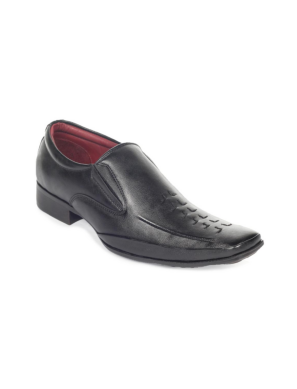

⬇------------------- изображение 13621.jpg -------------------⬇
Composition Grey shorts made of ComfortSoft 100% combed cotton, has light grey
and white panels with black piping on the sides, elasticated waistband covered
with a ComfortSoft fabric and a drawstring   Fit  Comfort   Wash care  Machine
wash warm with like colours Do not bleach Tumble dry low Warm iron  A stylish
and sporty short that can be worn on the beach, on a relaxed day at home or
during vacations, this product from hanes is created keeping your comfort in
mind. The luxurious ComfortSoft fabric not only retains its shape even after
repeated washes, but also offers superior comfort. And with the ComfortSoft
fabric covering the elasticated waistband, be assured of a pinch-free
comfortable fit, while you can further customise the fitting with the
drawstring. Wear this with Sports t-shirts or casual ones and revel in a
comfortable lifestyle.   Model statistics  The model wears size M in shorts,
with a length of 45 cm He

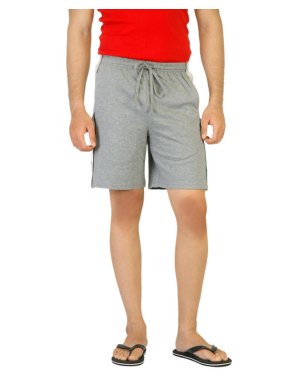

⬇------------------- изображение 56811.jpg -------------------⬇
White and pink floral printed woven tunic, has a mandarin collar with a split
neckline, three fourth sleeves with paneling on the cuffs, space tucks and
paneling on the mid arm, mirror work and embroidery on the yoke, and a vented
hem


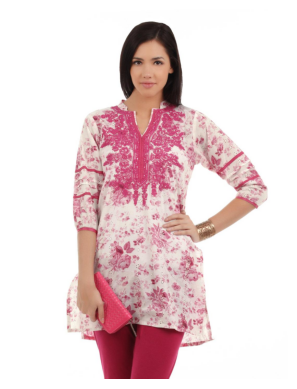

⬇------------------- изображение 44106.jpg -------------------⬇
Style Note hugo boss present an exclusive 'Element' gift set with these EDT for
men and a shower gel. This brand has perfected the craft of creating endlessly
stylish fragrances as this set will prove! Product Details hugo Element EDT for
men comes in a glass flacon Hugo Element shower gel for men comes in a plastic
tube Quantity Hugo Element EDT: 90 ml Hugo Element shower gel: 150 ml


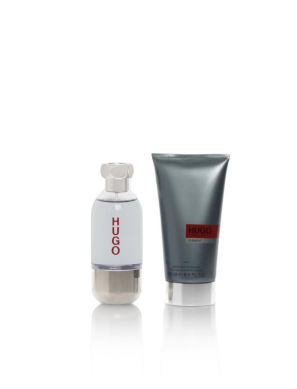

⬇------------------- изображение 22596.jpg -------------------⬇
Composition Red t-shirt made of 100% polyester, is engineered with Dri-Fit
technology, has a mock neck, short raglan sleeves and printed nike swoosh on the
left chest Fit Regular Wash care Machine wash cold with like colours Do not dry
clean or bleach Tumble dry low Warm iron Crafted from soft cotton-polyester
fabric and engineered with Dri-Fit technology, this t-shirt from nike offers
exemplary dry comfort, making it a great everyday choice for your healthy runs
and casual days. Team this printed tee with jeans and running shoes for a sporty
look. Add on a hooded sweatshirt for exemplary comfort during winters. Model
statistics The product is a size M on a model of height 6' and shoulders 18"


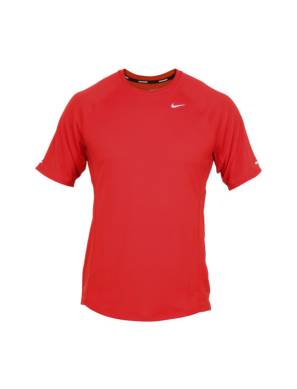

⬇------------------- изображение 17444.jpg -------------------⬇
Case style: Analogue watch, has a circular case and a stainless steel back Dial
style: Silver-toned dial Features: Has a chronographic display, a screw to reset
the time and two push-buttons to reset the features Strap style: Brown leather
strap, secured with a tang clasp Comes in a signature CASIO case


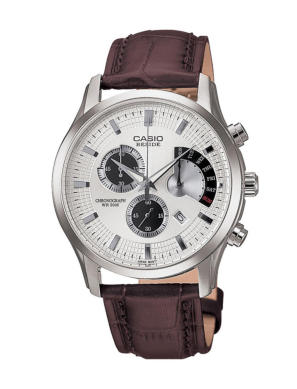

In [26]:
show_images (df_train.sample(10, random_state=RANDOM_STATE))

Описания данных 10 изображений являются корректными.

In [27]:
df_train.shape

(439, 4)

In [28]:
df_val.shape

(50, 2)

## Выводы по итогам EDA



- удалены образцы с пустыми или с незначищими описаниями (без букв)
- все изображения имеют разрешение  1080х1440
- всего изображения в тренировочном датасете осталось 38791, в валидационном - 4445
- описания выборочных 10 изображений являются корректными

## Подготовка датасета

Реализуем свой класс датасета, который будет подгружать картинки и соответствующие им текстовые описания.

In [29]:
class CLIPDataset(Dataset):
    def __init__(self, df, processor, tokenizer, base_path):
        self.df = df
        self.processor = processor
        self.tokenizer = tokenizer
        self.base_path = base_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.base_path, row['image'])
        description = row['description']

        try:
            image = Image.open(image_path).convert("RGB")
            image_inputs = self.processor(images=image, return_tensors="pt")
            
            text_inputs = self.tokenizer(
                description, 
                padding="max_length", 
                truncation=True, 
                max_length=self.tokenizer.model_max_length, 
                return_tensors="pt"
            )

            # Удаляем размерность батча, добавленную процессором/токенайзером
            return {
                'pixel_values': image_inputs['pixel_values'].squeeze(),
                'input_ids': text_inputs['input_ids'].squeeze(),
                'attention_mask': text_inputs['attention_mask'].squeeze()
            }
        
        except FileNotFoundError:
            print(f"Файл не найден: {image_path}. Пропускаем.")
            return None
        except Exception as e:
            print(f"Ошибка при загрузке {image_path}: {e}. Пропускаем.")
            return None

def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

## Загрузка модели

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained(MODEL_NAME).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME)

train_dataset = CLIPDataset(df_train, processor, tokenizer, base_path=IMAGES_PATH)
val_dataset = CLIPDataset(df_val, processor, tokenizer, base_path=IMAGES_PATH)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_fn, 
    num_workers=2
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn, 
    num_workers=2
)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Прогоним через модель несколько примеров из датасета и посмотрите, какие получаются CLIP-скоры:

In [ ]:
def calculate_clip_score(image_features, text_features):
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    logits_per_image = torch.matmul(image_features, text_features.t())
    return logits_per_image.diag().mean().item()

model.eval()
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    if sample_batch:
        sample_batch = {k: v.to(device) for k, v in sample_batch.items()}
        
        outputs = model(
            input_ids=sample_batch['input_ids'], 
            attention_mask=sample_batch['attention_mask'], 
            pixel_values=sample_batch['pixel_values'], 
            return_loss=True
        )
        
        image_features = outputs.image_embeds
        text_features = outputs.text_embeds
        initial_loss = outputs.loss.item()
        initial_score = calculate_clip_score(image_features, text_features)
        
        print(f"Начальная функция потерь (батч): {initial_loss:.4f}")
        print(f"Начальный CLIP Score (батч): {initial_score:.4f}")

## Дообучение

# Этап 2. Реализация системы поиска товаров

## Подготовка данных

## Функция поиска товаров

## Тестирование

# Выводы

